In [ ]:
# Install libraries
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import io
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

%matplotlib inline

# Nova seção

In [ ]:
# Uploading dataset
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [ ]:
# Peeking at data
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [ ]:
# Dropping unimportant columns
btc = btc.drop(['Date', 'Symbol'], axis=1)

In [ ]:
# Selecting feature for prediction
features = btc['Close']
outcome = btc.drop(['Close'], axis=1)

In [ ]:
outcome

,Open,High,Low,Volume From,Volume To
0,7459.11,7640.46,7380.00,2722.80000,2.042265e+07
1,7584.15,7661.85,7326.94,8491.93000,6.342069e+07
2,7505.00,7734.99,7269.00,11033.72000,8.293137e+07
3,7987.70,8030.00,7433.19,14905.99000,1.148104e+08
4,8393.44,8400.00,7950.00,6589.43000,5.389753e+07
...,...,...,...,...,...
1268,377.10,377.10,377.10,0.00000,0.000000e+00
1269,378.00,378.00,377.10,0.01000,3.770000e+00
1270,378.00,378.00,377.01,0.54660,2.065200e+02
1271,370.00,378.00,370.00,15.01000,5.675070e+03


In [ ]:
# Since the dataset is backwards, we flip the dataset
features = pd.DataFrame(features)
features_flipped = features["Close"].values[::-1]
features_flipped = pd.DataFrame(features_flipped)
features_flipped

,0
0,370.00
1,378.00
2,378.00
3,377.10
4,377.10
...,...
1268,7987.70
1269,7505.00
1270,7584.15
1271,7459.11


In [ ]:
outcome_flipped = outcome.values[::-1]
outcome_flipped = pd.DataFrame(outcome_flipped)
outcome_flipped.columns = ["Open", "High", "Low", "Volume From", "Volume To"]
outcome_flipped

,Open,High,Low,Volume From,Volume To
0,300.00,370.00,300.00,0.05656,1.953000e+01
1,370.00,378.00,370.00,15.01000,5.675070e+03
2,378.00,378.00,377.01,0.54660,2.065200e+02
3,378.00,378.00,377.10,0.01000,3.770000e+00
4,377.10,377.10,377.10,0.00000,0.000000e+00
...,...,...,...,...,...
1268,8393.44,8400.00,7950.00,6589.43000,5.389753e+07
1269,7987.70,8030.00,7433.19,14905.99000,1.148104e+08
1270,7505.00,7734.99,7269.00,11033.72000,8.293137e+07
1271,7584.15,7661.85,7326.94,8491.93000,6.342069e+07


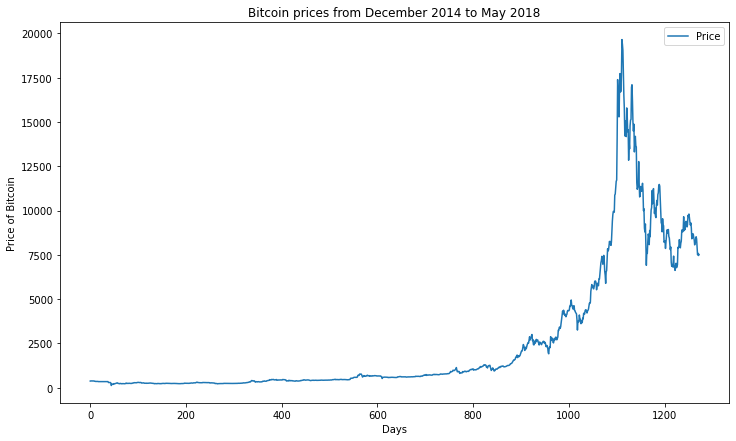

In [ ]:
# Plotting Close Prices
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.plot(features_flipped, label='Price')
plt.legend()
plt.show()

In [ ]:
# Reshaping features into array
close_price = np.array(features_flipped).reshape(-1,1)

In [ ]:
# Standardize features and scaling to unit variance with StandardScaler
standard_scalar = StandardScaler()

close_priceSC = standard_scalar.fit_transform(close_price)

In [ ]:
# Formatting data into ranges
# Creating Features and Labels datasets by windowing the data.
# stepsize - how many data points we are going to use to predict the next datapoint in the sequence 

stepsize = 32

X = []
y = []
for i in range(stepsize, len(close_priceSC)):
    X.append(close_priceSC[i-stepsize:i, 0])
    y.append(close_priceSC[i,0])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(1241, 32) (1241,)


In [ ]:
# Splitting the data into 80% train and 20% test split
X_train = X[:1018 ,:]
X_test = X[1018 :,:]

y_train = y[:1018 ]
y_test = y[1018 :]

In [ ]:
print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 32)
y_train size: (1018,)
X_test size: (223, 32)
y_test size: (223,)


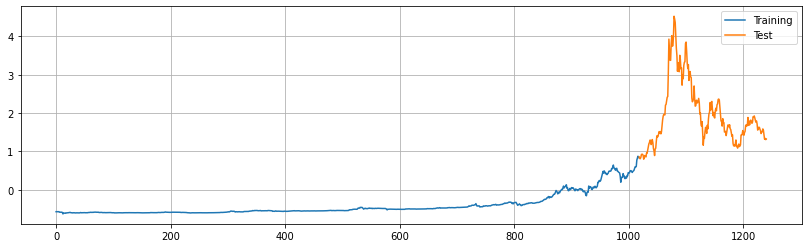

In [ ]:
# Plotting training and test data
plt.figure(figsize=(14,4))
plt.plot(range(1018),y_train)
plt.plot(range(1018, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()

In [ ]:
# Reshaping data to feed the model
X_train = X_train.reshape(-1,stepsize,1)
X_test = X_test.reshape(-1,stepsize,1)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 32, 1)
y_train size: (1018,)
X_test size: (223, 32, 1)
y_test size: (223,)


In [ ]:
# Defining model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train.shape[1], 1))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['acc'])



In [ ]:
# Fitting model
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
16/16 [==============================] - 5s 35ms/step - loss: 0.2603 - acc: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0574 - acc: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0325 - acc: 0.0000e+00
Epoch 4/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0216 - acc: 0.0000e+00
Epoch 5/100
16/16 [==============================] - 1s 37ms/step - loss: 0.0211 - acc: 0.0000e+00
Epoch 6/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0200 - acc: 0.0000e+00
Epoch 7/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0175 - acc: 0.0000e+00
Epoch 8/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0171 - acc: 0.0000e+00
Epoch 9/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0156 - acc: 0.0000e+00
Epoch 10/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0161 - acc: 0.0000e+00
Epoch 11/

In [ ]:
# Prediction and measuring error
y_pred = model.predict(X_test)
MSE = mean_absolute_error(y_test, y_pred)

Text(0, 0.5, 'Price')

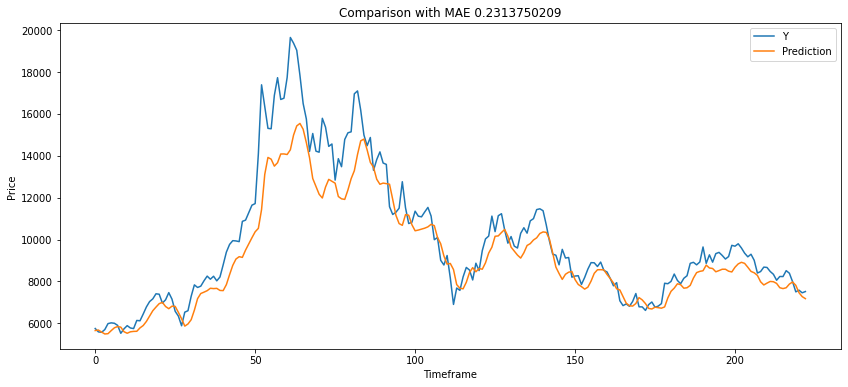

In [ ]:
# Plotting prediction in relation to original test data
plt.figure(figsize=(14,6))
plt.plot(standard_scalar.inverse_transform(y_test.reshape(-1,1)))
plt.plot(standard_scalar.inverse_transform(y_pred.reshape(-1,1)))
plt.title("Comparison with MAE {0:0.10f}".format(MSE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")